In [8]:
import zipfile
import tensorflow as tf
import numpy as np
import splitfolders
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split

# Data Collecting

## Unzip Dataset

In [9]:
local_zip = 'chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [10]:
base_dir = 'chest_xray'
os.listdir(base_dir)

['PNEUMONIA', 'NORMAL']

In [11]:
normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

#### l = []
for i in base_dir:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

## Exploratory Data Analysis

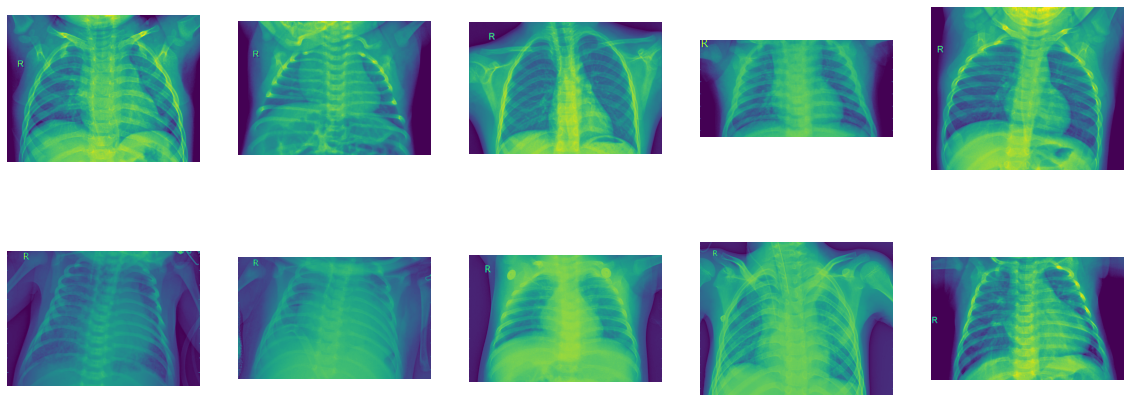

In [12]:
%matplotlib inline
files_normal = os.listdir(normal_dir)
files_pneumonia = os.listdir(pneumonia_dir)

nrows = 3
ncols = 5

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 5

images_normal = [os.path.join(normal_dir, fname)
                         for fname in files_normal[pic_index - 5:pic_index]]
images_pneumonia = [os.path.join(pneumonia_dir, fname)
                         for fname in files_pneumonia[pic_index - 5:pic_index]]

for i, img_path in enumerate(images_normal + images_pneumonia):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Data Preprocessing

## Split Data

In [13]:
base_dir = 'chest_xray'
splitfolders.ratio(base_dir, output = 'chest_xray', seed = 1337, ratio = (.6, .4))

train_dir = os.path.join('chest_xray', 'train')
validation_dir = os.path.join('chest_xray', 'val')

normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

Copying files: 5856 files [00:04, 1267.91 files/s]


In [14]:
# membagi direktori normal menjadi data train dan validasi data
train_normal_dir, validation_normal_dir = train_test_split(os.listdir(normal_dir), test_size = 0.4, train_size = 0.6)

# membagi direktori pneumonia menjadi data train dan validasi data
train_pneumonia_dir, validation_pneumonia_dir = train_test_split(os.listdir(pneumonia_dir), test_size = 0.4, train_size = 0.6)

In [15]:
# membuat direktori normal pada direktori data training
train_normal_dir = os.path.join(train_dir, 'normal')

# membuat direktori pneumonia pada direktori data training
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

# membuat direktori normal pada direktori data validation
validation_normal = os.path.join(validation_dir, 'normal')

# membuat direktori pneumonia pada direktori data validation
validation_pneumonia = os.path.join(validation_dir, 'pneumonia')

## Data Augmentation

In [31]:
def to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

In [45]:
train_dir = base_dir + "/train"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='nearest')

validation_dir = base_dir + "/val"
validation_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
train_generator = train_datagen.flow_from_directory(
  directory=train_dir,   
  target_size=(150,150),
  color_mode='grayscale',
  class_mode='binary',  
  shuffle=True,
  batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
  directory=validation_dir,  
  target_size=(150,150),
  color_mode='grayscale',
  class_mode='binary',
  shuffle=True,
  batch_size=64)

Found 3512 images belonging to 2 classes.
Found 2344 images belonging to 2 classes.


## Modelling

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128 , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')
])

In [48]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_25 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 75, 75, 64)      

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 patience = 2,
                                                 verbose=1,
                                                 factor=0.3,
                                                 min_lr=0.000001)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [49]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
55/55 [==============================] - 56s 1s/step - loss: 0.8494 - accuracy: 0.8161 - val_loss: 4.9865 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 53s 975ms/step - loss: 0.3638 - accuracy: 0.8491 - val_loss: 11.1556 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8733
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
55/55 [==============================] - 53s 970ms/step - loss: 0.3105 - accuracy: 0.8733 - val_loss: 8.2846 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 52s 958ms/step - loss: 0.2290 - accuracy: 0.9129 - val_loss: 11.8216 - val_accuracy: 0.7295 - lr: 3.0000e-04
Epoch 5/100
55/55 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9183
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
55/55 [==============================] 

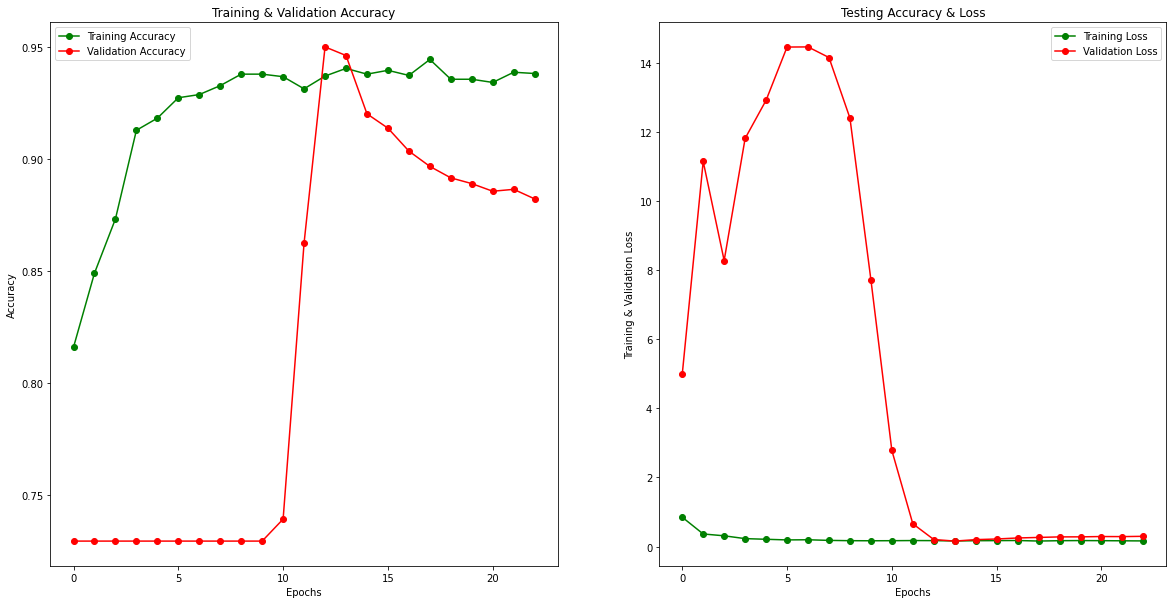

In [50]:
epochs = [i for i in range(23)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()